In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from collections import Counter

import gc
import cloudpickle

import torch

import os, sys
import random

import warnings

import xgboost as xgb

print('Using \033[34mXGBoost', xgb.__version__, '\033[0m')

Using XGBoost 1.5.0 


In [11]:
columns2float16 = ['CAPITAL_RANK', 'CAPTION_SENSE_CAPITAL_RANK_3', 'TITLE_SENSE_CAPITAL_RANK_3', 'CAPTION_SENSE_CAPITAL_RANK_3_mean-std', 'TITLE_SENSE_CAPITAL_RANK_3_mean-std',
    'WEAK_ENTITY_RANK', 'TITLE_VISUAL_WEAK_ENTITY_RANK_3', 'TITLE_SENSE_WEAK_ENTITY_RANK_3', 'TITLE_VISUAL_WEAK_ENTITY_RANK_3_mean-std', 'CAPTION_VISUAL_WEAK_ENTITY_RANK_3',
    'TITLE_SENSE_WEAK_ENTITY_RANK_3_mean-std', 'XTITLE_WEAK_ENTITY_RANK', 'CAPTION_VISUAL_WEAK_ENTITY_RANK_3_mean-std', 'CAPTION_SENSE_WEAK_ENTITY_RANK_3',
    'CAPITAL_ACRONYM_RANK', 'CRUDE_ACRONYM_RANK', 'FUZZY_TITLE_RANK', 'XCAPTION_WEAK_ENTITY_RANK', 'CAPTION_SENSE_WEAK_ENTITY_RANK_3_mean-std',
    'VISUAL_UNDIGIT_CAPTION', 'VISUAL_UNDIGIT_TITLE', 'VISUAL_FINAL_CAPTION', 'VISUAL_FINAL_TITLE', 'CAPTION_VISUAL_AGGR', 'TITLE_VISUAL_AGGR',
    'SENSE_UNDIGIT_FILENAME_UNDIGIT_TITLE',
    'SENSE_FINAL_FILENAME_UNDIGIT_TITLE',
    'TITLE_SENSE_AGGR',
    'SENSE_UNDIGIT_FILENAME_FINAL_TITLE',
    'SENSE_FINAL_FILENAME_FINAL_TITLE',
    'FUZZY_CAPTION_RANK',
    'TITLE_VISUAL_FUZZY_TITLE_RANK_3',
    'SENSE_UNDIGIT_FILENAME_UNDIGIT_CAPTION',
    'SENSE_FINAL_FILENAME_UNDIGIT_CAPTION',
    'TITLE_VISUAL_TITLE_CROSS_FUZZY_RANK_3',
    'TITLE_VISUAL_FUZZY_CAPTION_RANK_3',
    'TITLE_CROSS_FUZZY_RANK',
    'CAPTION_SENSE_AGGR',
    'SENSE_UNDIGIT_FILENAME_FINAL_CAPTION',
    'TITLE_VISUAL_FUZZY_TITLE_RANK_3_mean-std',
    'SENSE_FINAL_FILENAME_FINAL_CAPTION',
    'TITLE_VISUAL_CRUDE_ACRONYM_RANK_3',
    'TITLE_VISUAL_FUZZY_CAPTION_RANK_3_mean-std',
    'TITLE_VISUAL_CAPTION_CROSS_FUZZY_RANK_3',
    'CAPTION_VISUAL_FUZZY_TITLE_RANK_3',
    'TITLE_SENSE_FUZZY_TITLE_RANK_3',
    'TITLE_VISUAL_CRUDE_ACRONYM_RANK_3_mean-std',
    'TITLE_VISUAL_CAPITAL_ACRONYM_RANK_3_mean-std',
    'TITLE_VISUAL_CAPITAL_ACRONYM_RANK_3',
    'TITLE_SENSE_FUZZY_CAPTION_RANK_3',
    'TITLE_VISUAL_TITLE_CROSS_FUZZY_RANK_3_mean-std',
    'CAPTION_VISUAL_TITLE_CROSS_FUZZY_RANK_3',
    'TITLE_SENSE_CAPTION_CROSS_FUZZY_RANK_3',
    'TITLE_VISUAL_NUMERIC_RANK_3',
    'CAPTION_CROSS_FUZZY_RANK',
    'TITLE_SENSE_TITLE_CROSS_FUZZY_RANK_3']

print(len(columns2float16))


def load_features(path, k, train=True):
    part_folder = 'train-{0:02d}'.format(k) if train else 'valid-{0:02d}'.format(k)
    X = pd.read_parquet(os.path.join(path, part_folder, 'features.parquet'))
    y = pd.read_parquet(os.path.join(path, part_folder, 'targets.parquet')).iloc[:, 0].values
    
    with open(os.path.join(path, part_folder, 'group.pickle'), 'rb') as file:
        group = cloudpickle.load(file)
        
    for c, dtype in X.dtypes.iteritems():
        if dtype == np.float64:
            X[c] = X[c].astype(np.float32)
        
        if c.startswith('DCAPTION') or c.startswith('DTITLE') or c.startswith('DFILENAME') or c.startswith('DIMG'):
            X[c] = X[c].astype(np.float16)
            
            
    for c in columns2float16:
        X[c] = X[c].astype(np.float16)
            
    X.fillna(-1000., inplace=True)
    
    _ = X
    X = _.copy()
    del _
    gc.collect()
        
    return X, y, group

56


In [17]:
X_test, y_test, group_test = load_features('../input/data-for-model-00', k=70, train=False)

In [20]:
import itertools
import tqdm


l_n_estimators = [350]
l_colsample_bytree = [1]

l_max_depth = [3]
l_learning_rates = [0.03]
l_reg_alphas = [1.]
l_reg_lambdas = [5.]


best_score = float('-inf')
best_params = None
best_ranker = None

adapt_best_score = float('-inf')
adapt_best_params = None


params = list(itertools.product(l_n_estimators, l_colsample_bytree, l_max_depth, l_learning_rates, l_reg_alphas, l_reg_lambdas))

runs = []

imp = 0

for n_estimators, colsample_bytree, max_depth, lr, reg_alpha, reg_lambda in params:
    params = {
        'objective': 'rank:ndcg',
        'eval_metric': 'ndcg',
        'n_estimators': n_estimators,
        'random_state': 1187,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'max_depth': max_depth,
        'learning_rate': lr,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,        
    }
    
    
    xgb_model = None

    for part in range(10):
        X_train, y_train, group_train = load_features('../input/data-for-model-01', k=part)
        if 'ranker' in globals():
            del ranker
            gc.collect()

        ranker = xgb.sklearn.XGBRanker(**params, tree_method='gpu_hist', gpu_id=0)

        fit_params = { 'eval_metric': ['ndcg'] }

        ranker.fit(X_train, y_train, group=group_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_group=[group_train, group_test], **fit_params, xgb_model=xgb_model)
        xgb_model = ranker.get_booster()
        
        del X_train
        del y_train
        del group_train
        
        gc.collect()
    
    result = ranker.evals_result()

    train_score = result['validation_0']['ndcg'][-1]
    test_score = result['validation_1']['ndcg'][-1]
    
    if test_score > best_score:
        best_score, best_params = test_score, params
        best_ranker = ranker
        
        print('\033[34mУЛУЧШЕНИЕ', best_score, imp, '\033[0m')
        print(best_params)
        print()
        print()
        
        
        ranker_filepath = 'ranker-{0:02d}.model'.format(imp)
        best_ranker.save_model(ranker_filepath)
        
        imp += 1

        
    runs.append((train_score, test_score, params))
    
    print('TRAIN SCORE', train_score, test_score)
    print(params)
    
    print()

УЛУЧШЕНИЕ 0.790887 0 
{'objective': 'rank:ndcg', 'eval_metric': 'ndcg', 'n_estimators': 350, 'random_state': 1187, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'max_depth': 3, 'learning_rate': 0.03, 'reg_alpha': 1.0, 'reg_lambda': 5.0}


TRAIN SCORE 0.805448 0.790887
{'objective': 'rank:ndcg', 'eval_metric': 'ndcg', 'n_estimators': 350, 'random_state': 1187, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'max_depth': 3, 'learning_rate': 0.03, 'reg_alpha': 1.0, 'reg_lambda': 5.0}



<AxesSubplot:>

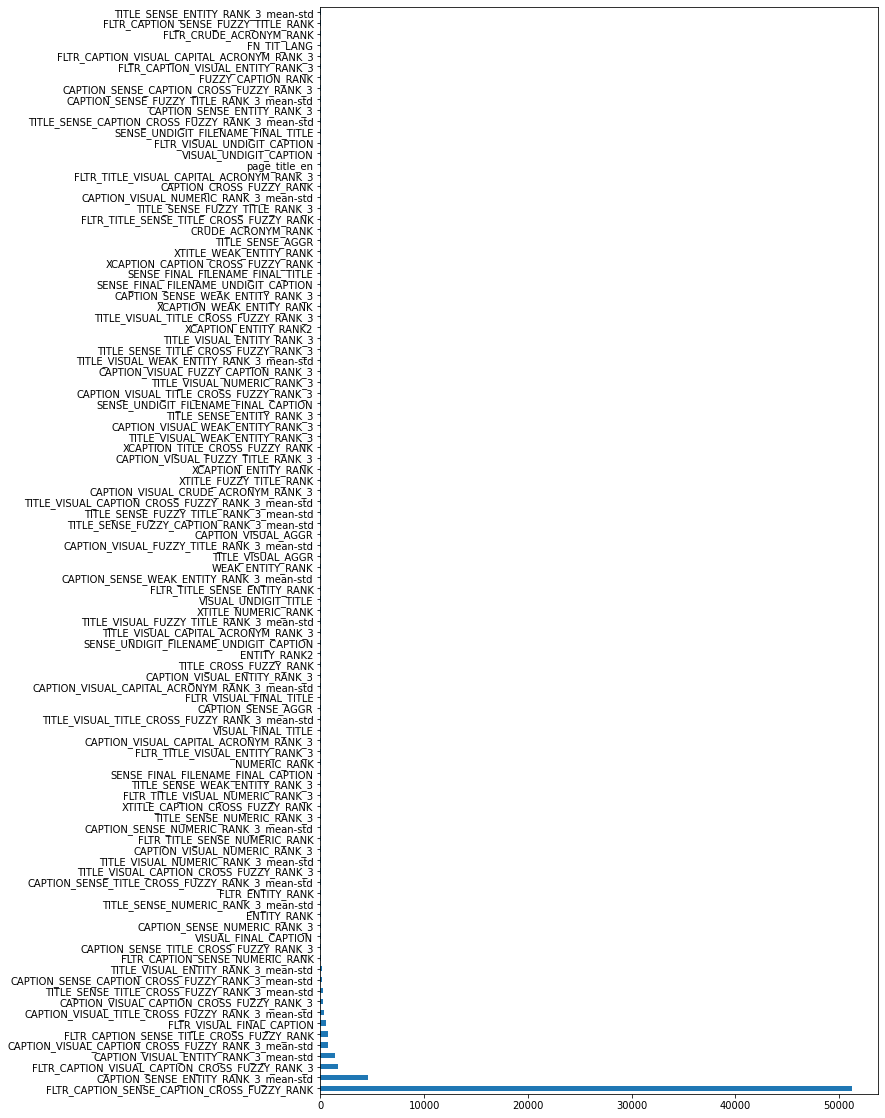

In [21]:
pd.Series(best_ranker.get_booster().get_score(importance_type='gain'), index=X_test.columns) \
   .nlargest(100) \
   .plot(kind='barh', figsize=(10, 20))